In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# import data
sales = pd.read_csv("/content/hk_sales_data.csv")
weather = pd.read_csv("/content/2024_weather_data.csv")

sales['date'] = pd.to_datetime(sales['Sent Date']).dt.date
sales['time'] = pd.to_datetime(sales['Sent Date']).dt.time
weather['date'] = pd.to_datetime(weather['datetime']).dt.date

sales = sales[sales["Net Price"] >= 1]
sales = pd.merge(sales, weather, on='date', how='left')
sales = sales[sales["Void?"] == False]

sales = sales.drop([
    "Menu Item", "Sent Date", "description", "name", "icon",
    "datetime", "stations", "Void?", "sunrise", "sunset", "conditions"
], axis=1)

sales['datetime'] = pd.to_datetime(sales['date'].astype(str) + ' ' + sales['time'].astype(str))
sales.set_index('datetime', inplace=True)
sales['sale'] = np.log(sales['Net Price'] * sales["Qty"] + 1)
print(sales.columns)

alc_sales = sales[sales['Menu'] == 'BEVERAGES']
alc_sales = alc_sales[alc_sales['Menu Group'] != 'NA Beverages']
food_sales = sales[sales['Sales Category'] == 'Food']

alc_sales = alc_sales.select_dtypes(include=['number'])
food_sales = food_sales.select_dtypes(include=['number'])

alc_sales_resampled = alc_sales.resample('1h').sum()
food_sales_resampled = food_sales.resample('1h').sum()

Index(['Menu Group', 'Menu', 'Sales Category', 'Net Price', 'Qty', 'date',
       'time', 'tempmax', 'tempmin', 'temp', 'feelslikemax', 'feelslikemin',
       'feelslike', 'dew', 'humidity', 'precip', 'precipprob', 'precipcover',
       'preciptype', 'snow', 'snowdepth', 'windgust', 'windspeed', 'winddir',
       'sealevelpressure', 'cloudcover', 'visibility', 'solarradiation',
       'solarenergy', 'uvindex', 'severerisk', 'moonphase', 'sale'],
      dtype='object')


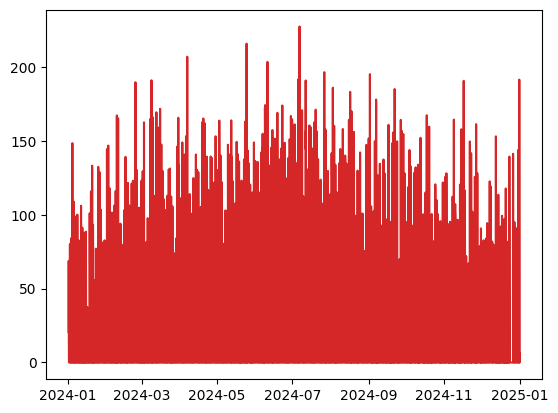

In [3]:
plt.plot(food_sales_resampled.index, food_sales_resampled['sale'], color='tab:red')
plt.show()

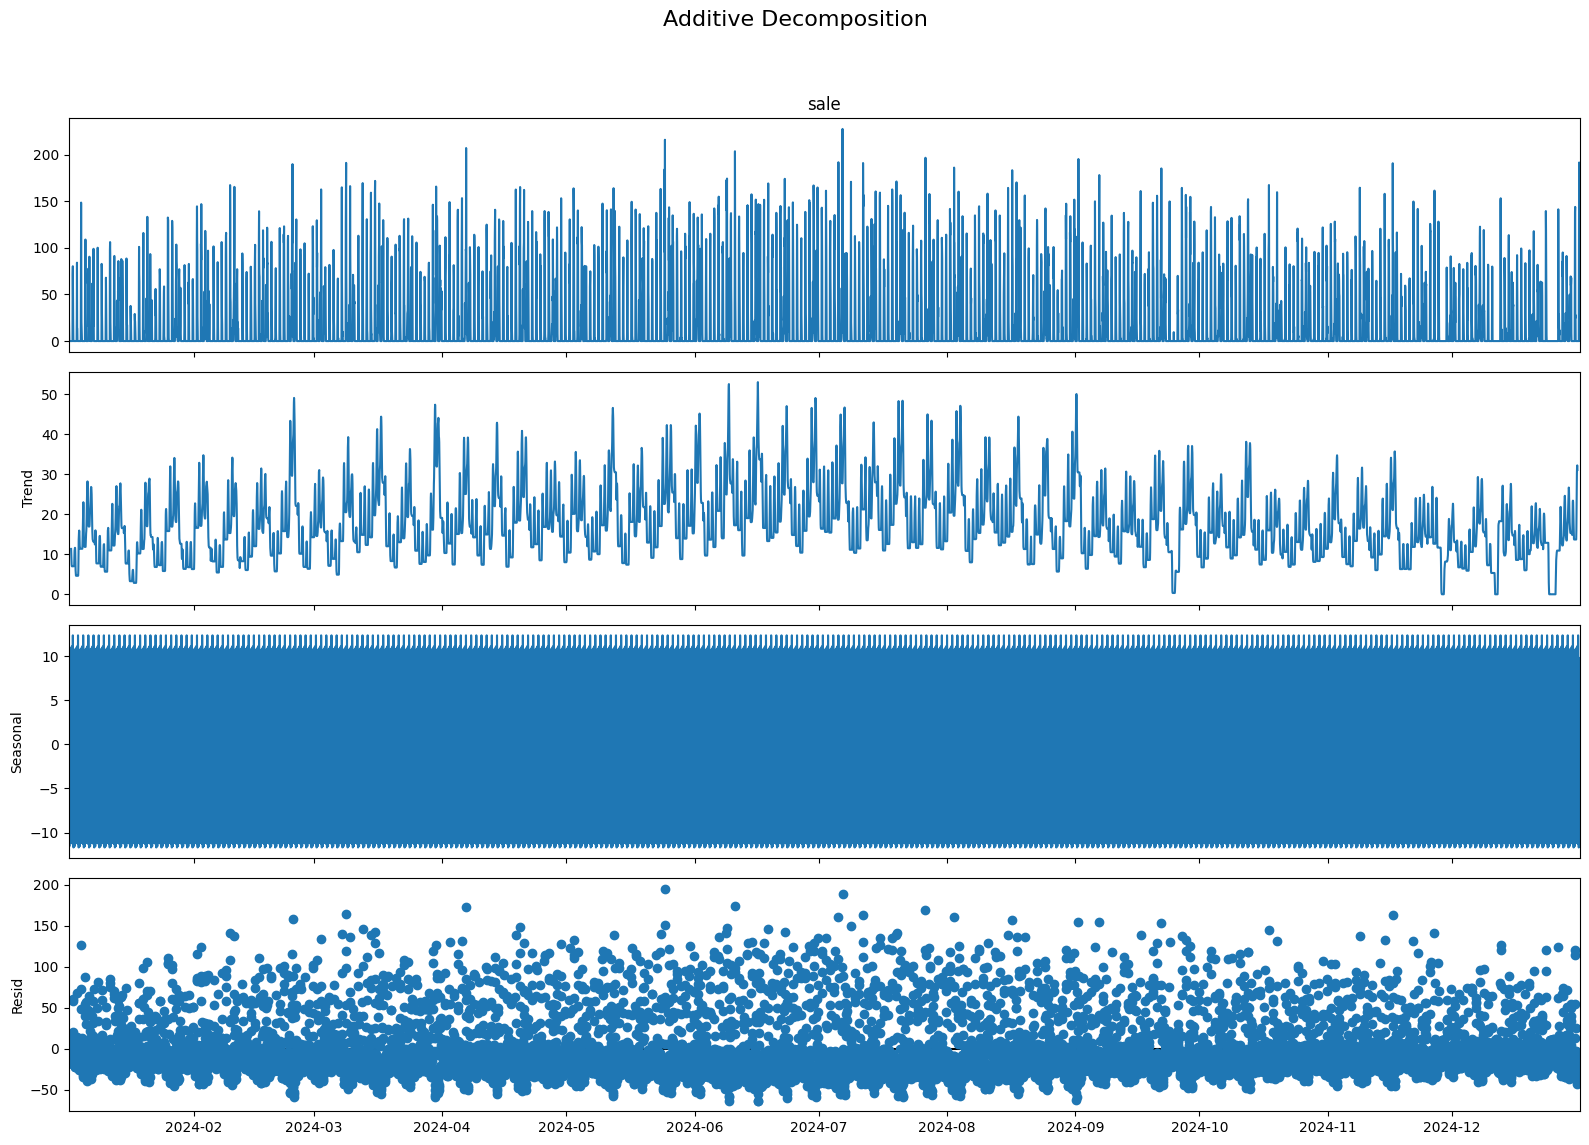

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

additive_decomposition = seasonal_decompose(food_sales_resampled['sale'], model='additive', period=30)

plt.rcParams.update({'figure.figsize': (16,12)})
additive_decomposition.plot().suptitle('Additive Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

[]

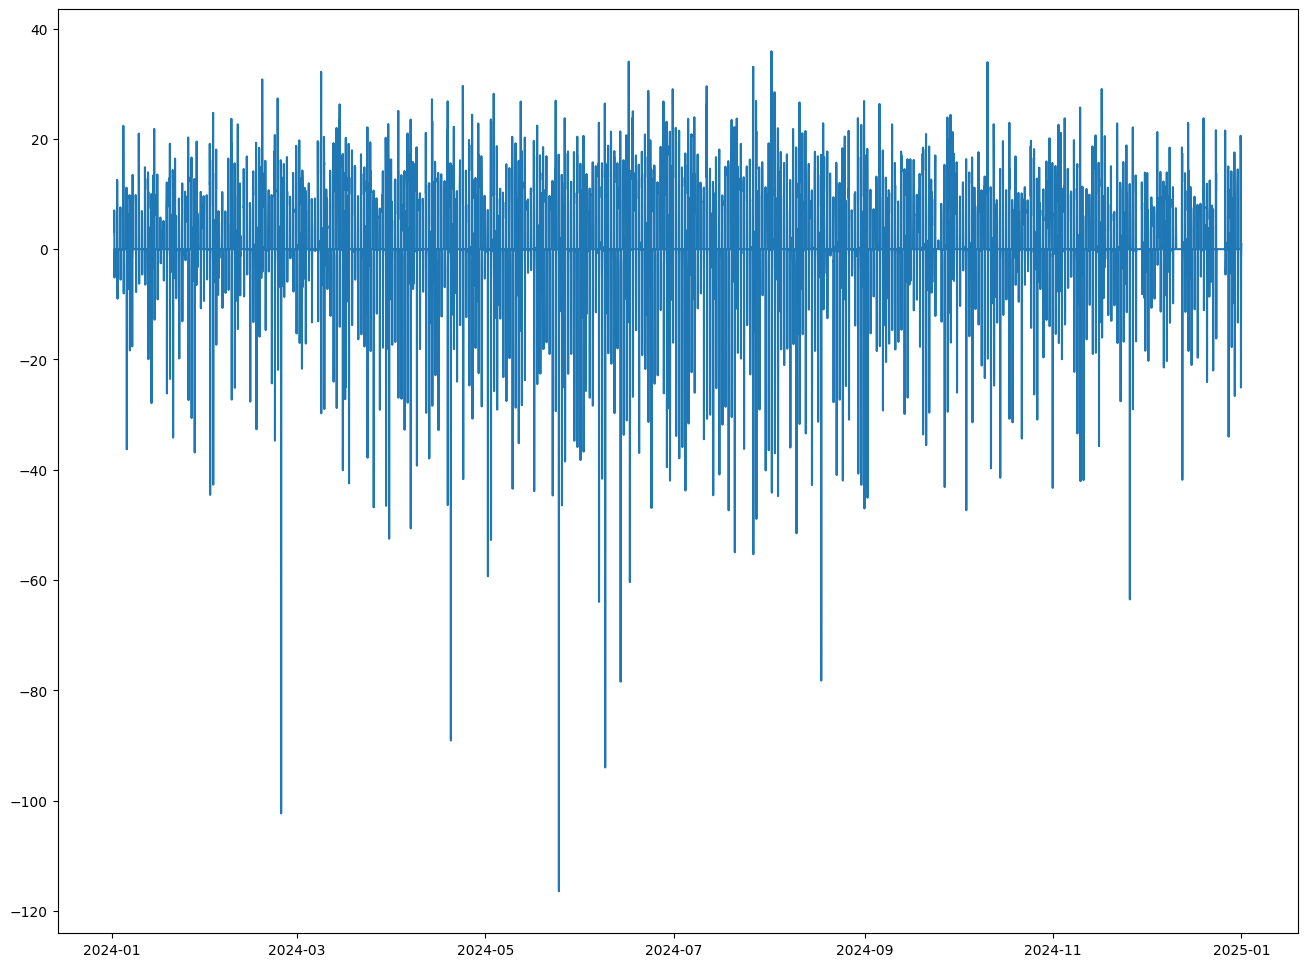

In [5]:
deseasonalized = food_sales_resampled['sale'].values / additive_decomposition.seasonal
plt.plot(deseasonalized)
plt.plot()

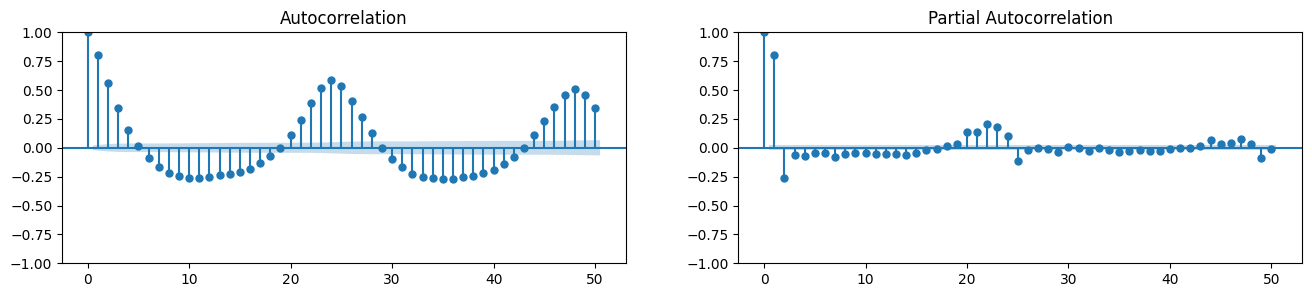

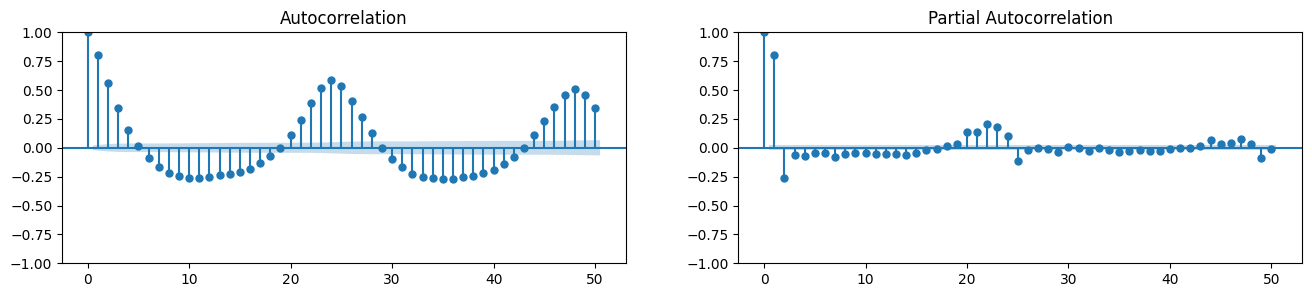

In [6]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(alc_sales_resampled['sale'].tolist(), lags=50, ax=axes[0])
plot_pacf(alc_sales_resampled['sale'].tolist(), lags=50, ax=axes[1])

In [7]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(food_sales_resampled['sale'].dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -11.369114606481016
p-value: 9.071149123159461e-21


                                     SARIMAX Results                                      
Dep. Variable:                               sale   No. Observations:                 8767
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 24)   Log Likelihood              -36877.316
Date:                            Thu, 06 Mar 2025   AIC                          73764.631
Time:                                    18:30:53   BIC                          73800.011
Sample:                                01-01-2024   HQIC                         73776.687
                                     - 12-31-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6345      0.013     49.672      0.000       0.609       0.660
ma.L1         -0.2024      0.015   

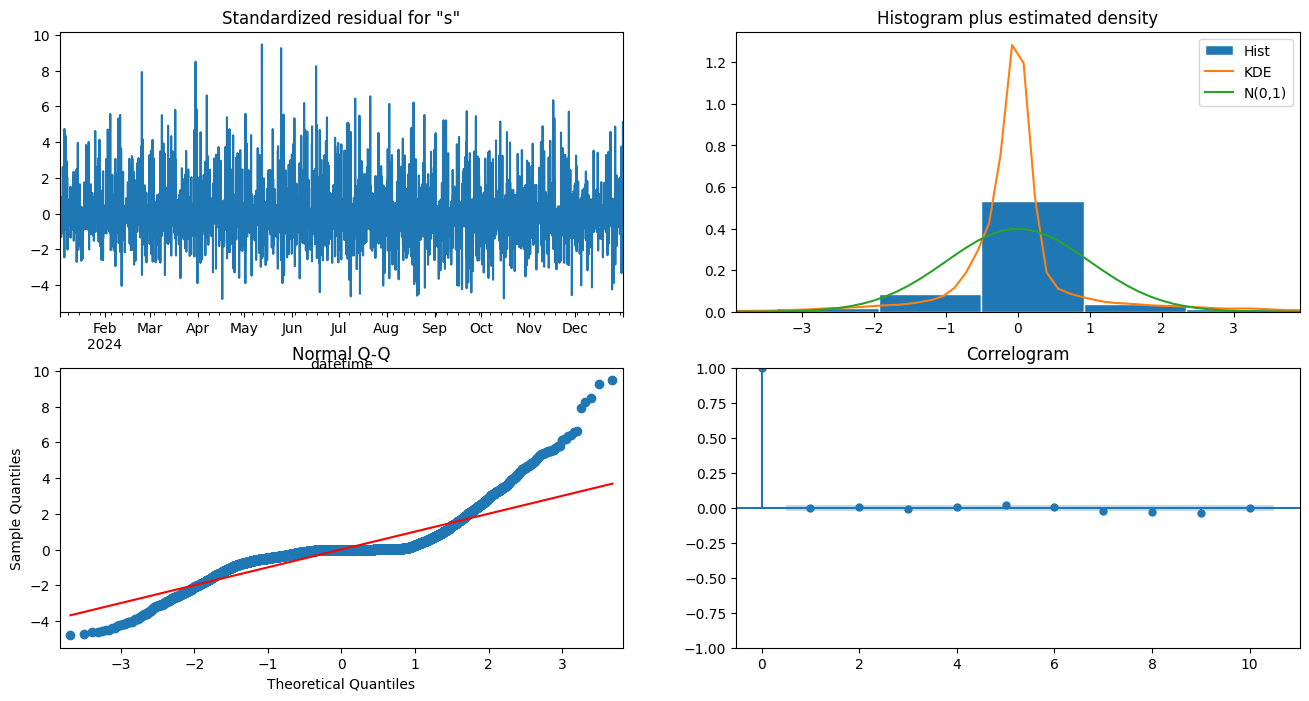

In [10]:
from statsmodels.tsa.arima.model import sarimax
model = sarimax.SARIMAX(food_sales_resampled['sale'],
                order=(1, 0, 1),
                seasonal_order=(1, 1, 1, 24))
model_fit = model.fit()

print(model_fit.summary())
model_fit.plot_diagnostics(figsize=(16, 8))
plt.show()

In [9]:
forecast_steps = 48
forecast = model_fit.forecast(steps=forecast_steps)

plt.figure(figsize=(12, 6))
plt.plot(food_sales_resampled.index, food_sales_resampled['sale'], label='Historical Sales')
plt.plot(pd.date_range(food_sales_resampled.index[-1], periods=forecast_steps, freq='H'),
         forecast, label='Forecast', color='red')
plt.legend()
plt.show()

ValueError: Provided exogenous values are not of the appropriate shape. Required (48, 3), got (48, 2).